# BA878 Gender Disparities in ICU Outcomes

In [24]:
#!pip install lifelines

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

import pandas as pd
import numpy as np

from google.cloud import bigquery

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from lifelines import CoxPHFitter
from scipy import stats
from scipy.stats import fisher_exact, chi2_contingency


# Initialize a BigQuery client
client = bigquery.Client(project='ba878-project')

In [26]:
table_ref = client.dataset('MIMIC_4').table('WIP_final_df')

# Fetch the table schema (optional, for verification)
table = client.get_table(table_ref)

# Load all data from the table into a DataFrame
df_final = client.list_rows(table).to_dataframe()

df_final.head()

,subject_id,hadm_id,age,gender,bmi,charlson_comorbidity_index,apsiii,days_to_death,death_within_28_days,death_within_365_days,...,admission_temperature,admission_temperature_c,admission_mean_blood_pressure,max_heart_rate_24h,arterial_ph,hemoglobin_g_dl,first_gcs_total,bun_mg_dl,creatinine_mg_dl,bilirubin_mg_dl
0,11466140,23594972,67,M,30.9,<NA>,<NA>,99999,0,0,...,NaN,NaN,NaN,76.0,NaN,NaN,5.0,NaN,NaN,NaN
1,14371035,27960021,54,F,28.7,<NA>,<NA>,99999,0,0,...,NaN,NaN,NaN,112.0,NaN,NaN,3.0,NaN,NaN,NaN
2,10691194,24438843,74,F,25.9,<NA>,<NA>,99999,0,0,...,NaN,NaN,NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN
3,19730381,23854430,56,M,29.5,<NA>,<NA>,99999,0,0,...,NaN,NaN,67.0,103.0,NaN,NaN,3.0,NaN,NaN,NaN
4,11618742,27083914,72,M,NaN,<NA>,<NA>,99999,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

Dropping columns with systematic missing pattern

In [27]:
df_final = df_final.dropna(subset=['had_invasive_ventilation', 'had_vasopressor_use', 'std_sofa'], axis=0)

In [28]:
df_final.isnull().sum()

subject_id                                  0
hadm_id                                     0
age                                         0
gender                                      0
bmi                                      2089
charlson_comorbidity_index                  0
apsiii                                      0
days_to_death                               0
death_within_28_days                        0
death_within_365_days                       0
has_hypertension                            0
had_invasive_ventilation                    0
had_noninvasive_ventilation                 0
had_vasopressor_use                         0
has_diabetes                                0
has_dyslipidaemia                           0
has_coronary_heart_disease                  0
has_severe_valvular_heart_disease           0
has_heart_failure                           0
has_peripheral_vascular_disease             0
has_prior_stroke                            0
had_rrt                           

In [29]:
merged_df=df_final.copy()

#### Imputation

In [30]:
# Select only the columns to impute
columns_to_impute = ['bmi', 'admission_temperature', 'admission_temperature_c', 'max_heart_rate_24h', 'arterial_ph', 'hemoglobin_g_dl', 'first_gcs_total', 'bun_mg_dl', 'creatinine_mg_dl']
imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors as needed

# Apply the imputer only to the selected columns
merged_df[columns_to_impute] = imputer.fit_transform(merged_df[columns_to_impute])

print(merged_df.isnull().sum())  # Check if there are any remaining missing values

subject_id                                  0
hadm_id                                     0
age                                         0
gender                                      0
bmi                                         0
charlson_comorbidity_index                  0
apsiii                                      0
days_to_death                               0
death_within_28_days                        0
death_within_365_days                       0
has_hypertension                            0
had_invasive_ventilation                    0
had_noninvasive_ventilation                 0
had_vasopressor_use                         0
has_diabetes                                0
has_dyslipidaemia                           0
has_coronary_heart_disease                  0
has_severe_valvular_heart_disease           0
has_heart_failure                           0
has_peripheral_vascular_disease             0
has_prior_stroke                            0
had_rrt                           

Dropping columns with large missing values

In [31]:
merged_df.drop(['admission_mean_blood_pressure', 'bilirubin_mg_dl', 'bmi'], axis= 1, inplace= True)

In [32]:
merged_df.isna().sum()

subject_id                               0
hadm_id                                  0
age                                      0
gender                                   0
charlson_comorbidity_index               0
apsiii                                   0
days_to_death                            0
death_within_28_days                     0
death_within_365_days                    0
has_hypertension                         0
had_invasive_ventilation                 0
had_noninvasive_ventilation              0
had_vasopressor_use                      0
has_diabetes                             0
has_dyslipidaemia                        0
has_coronary_heart_disease               0
has_severe_valvular_heart_disease        0
has_heart_failure                        0
has_peripheral_vascular_disease          0
has_prior_stroke                         0
had_rrt                                  0
has_copd                                 0
has_chronic_kidney_disease               0
sofa_slope 

Removing incorrect records

In [33]:
# Count the number of negative values in 'days_to_death'
negative_count = (merged_df['days_to_death'] < 0).sum()

print(f"Number of negative values in 'days_to_death': {negative_count}")

Number of negative values in 'days_to_death': 2


In [34]:
merged_df = merged_df[merged_df['days_to_death'] >= 0]

# Statistical Testings

Checking for gender split

In [35]:
# Count the occurrences of each unique value in the 'gender' column
gender_counts = merged_df['gender'].value_counts()

# Display the counts
print(gender_counts)

gender
M    4411
F    3767
Name: count, dtype: int64


### Chi-Square for Categorical Value Testings

#### Gender and Death within One-year

In [36]:
contingency_table2 = pd.crosstab(merged_df['gender'], merged_df['death_within_365_days'])

# Perform Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table2)

# Print results
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")

# Set significance level
alpha = 0.05

# Determine if p-value is significant
if p_value <= alpha:
    print("The result is statistically significant. Reject the null hypothesis.")
else:
    print("The result is not statistically significant. Fail to reject the null hypothesis.")

Chi-square statistic: 0.06508828744860037
P-value: 0.7986272794954256
Degrees of freedom: 1
The result is not statistically significant. Fail to reject the null hypothesis.


#### Gender and Death within 28 Days

In [37]:
contingency_table = pd.crosstab(merged_df['gender'], merged_df['death_within_28_days'])

# Perform Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")
if p_value <= 0.05:
    print("The result is statistically significant. Reject the null hypothesis.")
else:
    print("The result is not statistically significant. Fail to reject the null hypothesis.")

Chi-square statistic: 0.43896144593060593
P-value: 0.507624147548221
The result is not statistically significant. Fail to reject the null hypothesis.


### Mann-Whitney U test

#### Gender and Death within One-year

In [38]:
male_group_365 = merged_df[merged_df['gender'] == 'M']['death_within_365_days']
female_group_365 = merged_df[merged_df['gender'] == 'F']['death_within_365_days']

In [39]:
stat, p = mannwhitneyu(male_group_365, female_group_365, alternative='two-sided')
print(f"Statistic: {stat}, p-value: {p}")

Statistic: 8282661.0, p-value: 0.7814883949939475


#### Gender and Death within 28 Days

In [40]:
male_group_28 = merged_df[merged_df['gender'] == 'M']['death_within_28_days']
female_group_28 = merged_df[merged_df['gender'] == 'F']['death_within_28_days']

In [41]:
stat, p = mannwhitneyu(male_group_28, female_group_28, alternative='two-sided')
print(f"Statistic: {stat}, p-value: {p}")

Statistic: 8246427.0, p-value: 0.49321524998995014


### Kaplan-Meier Plotting

In [42]:
male_df = merged_df[merged_df['gender'] == 'M']
female_df = merged_df[merged_df['gender'] == 'F']

In [43]:
merged_df['days_to_death'].describe()

count          8178.0
mean     42385.377721
std      49366.471831
min               0.0
25%               9.0
50%             163.0
75%           99999.0
max           99999.0
Name: days_to_death, dtype: Float64

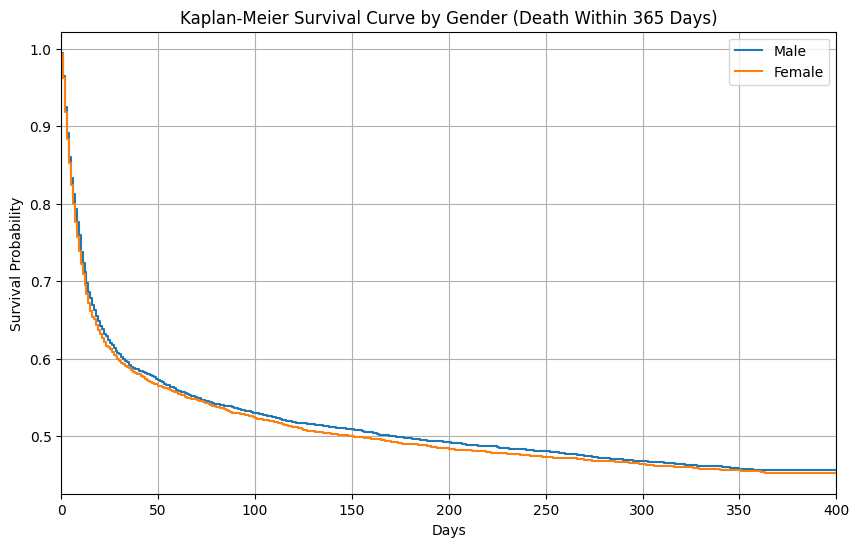

In [68]:
# Ensure correct data types
merged_df.loc[:, 'days_to_death'] = pd.to_numeric(merged_df['days_to_death'], errors='coerce')
merged_df.loc[:, 'death_within_365_days'] = merged_df['death_within_365_days'].astype(int)

# Initialize Kaplan-Meier fitter
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

# Fit Kaplan-Meier model for males
kmf_male.fit(durations=male_df['days_to_death'], event_observed=male_df['death_within_365_days'], label='Male')

# Fit Kaplan-Meier model for females
kmf_female.fit(durations=female_df['days_to_death'], event_observed=female_df['death_within_365_days'], label='Female')

# Plot the survival curves with x-axis limited to 0-400 days
plt.figure(figsize=(10, 6))
kmf_male.plot_survival_function(ci_show=False)
kmf_female.plot_survival_function(ci_show=False)

# Customize plot
plt.title('Kaplan-Meier Survival Curve by Gender (Death Within 365 Days)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.xlim(0, 400)
plt.grid(True)
plt.show()

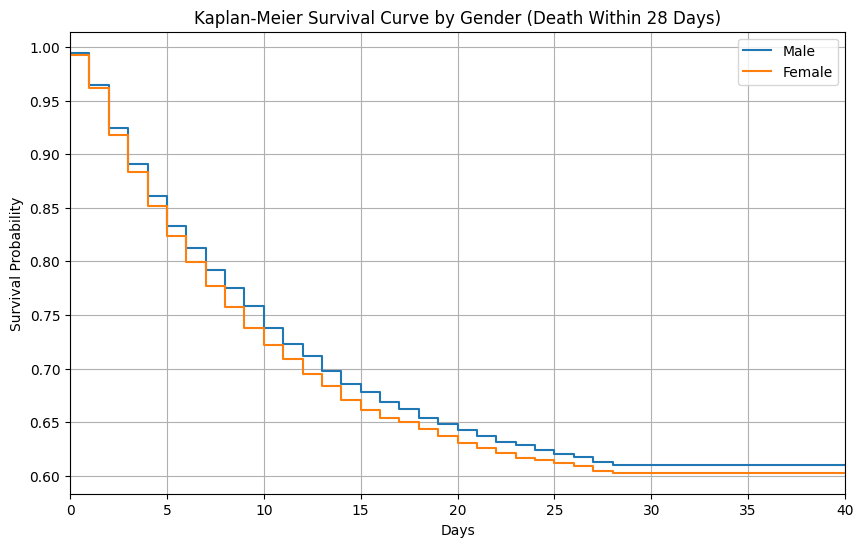

In [69]:
# Ensure correct data types
merged_df.loc[:, 'days_to_death'] = pd.to_numeric(merged_df['days_to_death'], errors='coerce')
merged_df.loc[:, 'death_within_28_days'] = merged_df['death_within_28_days'].astype(int)

# Initialize Kaplan-Meier fitter
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

# Fit Kaplan-Meier model for males
kmf_male.fit(durations=male_df['days_to_death'], event_observed=male_df['death_within_28_days'], label='Male')

# Fit Kaplan-Meier model for females
kmf_female.fit(durations=female_df['days_to_death'], event_observed=female_df['death_within_28_days'], label='Female')

# Plot the survival curves with x-axis limited to 0-400 days
plt.figure(figsize=(10, 6))
kmf_male.plot_survival_function(ci_show=False)
kmf_female.plot_survival_function(ci_show=False)



# Customize plot
plt.title('Kaplan-Meier Survival Curve by Gender (Death Within 28 Days)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.xlim(0, 40)
plt.grid(True)
plt.show()

### Log-Rank Test 

In [93]:
# Separate data into male and female groups
male_group = df_final[df_final['gender'] == 'M']
female_group = df_final[df_final['gender'] =='F']

In [95]:
from lifelines.statistics import logrank_test


results = logrank_test(
    durations_A=male_group['days_to_death'],
    durations_B=female_group['days_to_death'],
    event_observed_A=male_group['death_within_365_days'],
    event_observed_B=female_group['death_within_365_days']
)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.35 0.55      0.85

# Table 1 Creation

In [46]:
merged_copy = merged_df.copy()

#binning apsiii score
apsiii_min = merged_copy['apsiii'].min()
apsiii_max = merged_copy['apsiii'].max()

merged_copy['apsiii_strata'] = pd.qcut(merged_copy['apsiii'], q=3).cat.codes

In [47]:
merged_copy['days_to_death'] = pd.to_numeric(merged_copy['days_to_death'], errors='coerce')
merged_copy['death_within_365_days'] = merged_copy['death_within_365_days'].astype(int)

# Encode gender numerically (e.g., 0 = Male, 1 = Female)
merged_copy['gender'] = merged_copy['gender'].map({'M': 0, 'F': 1})

In [48]:
merged_copy['endpoint_365'] = np.minimum(merged_copy['days_to_death'], 365)
merged_copy['censored_365'] = (merged_copy['days_to_death'] <= 365).astype(int)

#truncate for 28 days
merged_copy['endpoint_28'] = np.minimum(merged_copy['days_to_death'], 28)
merged_copy['censored_28'] = (merged_copy['days_to_death'] <= 28).astype(int)

In [49]:
merged_copy.to_csv('final_df.csv', index=False)

In [50]:
continuous_vars = ['age', 'charlson_comorbidity_index', 'apsiii', 'days_to_death', 'sofa_slope', 'median_sofa', 'std_sofa', 'admission_temperature_c', 'max_heart_rate_24h', 'arterial_ph', 'hemoglobin_g_dl', 'first_gcs_total', 'bun_mg_dl', 'creatinine_mg_dl']

categorical_vars = ['death_within_28_days', 'death_within_365_days', 'has_hypertension', 'had_invasive_ventilation', 'had_noninvasive_ventilation', 'had_vasopressor_use', 'has_diabetes', 'has_dyslipidaemia', 'has_coronary_heart_disease', 'has_severe_valvular_heart_disease', 'has_heart_failure', 'has_peripheral_vascular_disease', 'has_prior_stroke', 'had_rrt', 'has_copd', 'has_chronic_kidney_disease', 'has_chronic_liver_disease', 'has_active_malignant_tumor', 'has_hiv', 'has_loss_of_autonomy', 'has_cognitive_dysfunction', 'has_respiratory_disorder_at_admission', 'has_sepsis_at_admission', 'has_trauma_at_admission', 'has_neurological_disease_at_admission', 'has_cardiac_arrest_at_admission', 'has_cardiogenic_shock_at_admission', 'has_hemorrhagic_shock_at_admission', 'apsiii_strata']

from scipy.stats import fisher_exact, chi2_contingency

def calculate_stats(df, var, is_continuous):
    female_data = merged_copy[merged_copy['gender']==1][var].dropna()
    male_data = merged_copy[merged_copy['gender']==0][var].dropna()
    
    if is_continuous:
        overall = f"{merged_copy[var].median():.1f} [{merged_copy[var].quantile(0.25):.1f}-{merged_copy[var].quantile(0.75):.1f}]"
        female = f"{female_data.median():.1f} [{female_data.quantile(0.25):.1f}-{female_data.quantile(0.75):.1f}]" if len(female_data) > 0 else "N/A"
        male = f"{male_data.median():.1f} [{male_data.quantile(0.25):.1f}-{male_data.quantile(0.75):.1f}]" if len(male_data) > 0 else "N/A"
        
        if len(female_data) > 0 and len(male_data) > 0:
            _, p_value = stats.mannwhitneyu(female_data, male_data, alternative='two-sided')
        else:
            p_value = np.nan
    else:
        overall = f"{df[var].sum()} ({merged_copy[var].mean()*100:.1f}%)"
        female = f"{female_data.sum()} ({female_data.mean()*100:.1f}%)" if len(female_data) > 0 else "N/A"
        male = f"{male_data.sum()} ({male_data.mean()*100:.1f}%)" if len(male_data) > 0 else "N/A"
        
        contingency_table = pd.crosstab(df['gender'], df[var])
        if contingency_table.shape == (2, 2):
            _, p_value = fisher_exact(contingency_table)
        elif contingency_table.shape[0] == 2 and contingency_table.shape[1] > 2:
            _, p_value, _, _ = chi2_contingency(contingency_table)
        else:
            p_value = np.nan
    
    return pd.Series({'Overall': overall, 'Female': female, 'Male': male, 'P-value': f"{p_value:.3f}" if not np.isnan(p_value) else "N/A"})

table1 = pd.DataFrame()

for var in continuous_vars + categorical_vars:
    new_row = calculate_stats(merged_copy, var, var in continuous_vars).to_frame().T
    table1 = pd.concat([table1, new_row], ignore_index=True)

table1.index = continuous_vars + categorical_vars
table1['Variable'] = table1.index
table1['Type'] = ['Continuous' if var in continuous_vars else 'Categorical' for var in table1.index]
table1 = table1[['Variable', 'Type', 'Overall', 'Female', 'Male', 'P-value']]

In [51]:
table1[['Overall', 'Female', 'Male', 'P-value']]

,Overall,Female,Male,P-value
age,69.0 [58.0-78.0],70.0 [59.0-79.0],69.0 [57.0-78.0],0.000
charlson_comorbidity_index,6.0 [4.0-8.0],6.0 [4.0-8.0],6.0 [4.0-8.0],0.035
apsiii,51.0 [37.0-68.0],51.0 [38.0-68.0],51.0 [37.0-69.0],0.987
days_to_death,163.0 [9.0-99999.0],149.0 [9.0-99999.0],171.0 [10.0-99999.0],0.367
sofa_slope,-0.0 [-0.0-0.0],-0.0 [-0.0-0.0],-0.0 [-0.0-0.0],0.611
median_sofa,4.0 [3.0-7.0],4.0 [2.0-7.0],5.0 [3.0-7.0],0.000
std_sofa,1.8 [1.2-2.4],1.7 [1.2-2.4],1.8 [1.2-2.5],0.003
admission_temperature_c,36.8 [36.4-37.2],36.8 [36.4-37.2],36.8 [36.4-37.2],0.015
max_heart_rate_24h,104.0 [91.0-120.0],105.0 [92.0-120.0],104.0 [90.0-119.0],0.001
arterial_ph,7.4 [7.3-7.4],7.4 [7.3-7.4],7.4 [7.3-7.4],0.055


# One-year End Point

## One-year Cox Proportional Hazard - Unadjusted

In [52]:
cph = CoxPHFitter()

cph.fit(
    merged_copy[['gender', 'endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.018878,1.019057,0.030024,-0.039969,0.077725,0.960819,1.080825,0.0,0.628748,0.529514,0.91726


In [53]:
cph.hazard_ratios_

covariate
gender    1.019057
Name: exp(coef), dtype: float64

In [54]:
cph.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.782765
Name: 365.0, dtype: float64

In [55]:
cph.check_assumptions(merged_copy[['gender', 'endpoint_365', 'censored_365']]
                      ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

## One-year Cox Proportional Hazard - Adjusted

In [56]:
cph_aj = CoxPHFitter()
cph_aj.fit(merged_copy[['gender', 'charlson_comorbidity_index', 'apsiii_strata', 'endpoint_365', 'censored_365', 'std_sofa']],  
           duration_col='endpoint_365',
           event_col='censored_365',
           formula="apsiii_strata * charlson_comorbidity_index * std_sofa  * gender"
          )

cph_aj.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
apsiii_strata,0.981341,2.668032,0.148832,0.689636,1.273046,1.992990,3.571716,0.0,6.593623,4.292194e-11,34.439494
charlson_comorbidity_index,0.192699,1.212517,0.024811,0.144069,0.241328,1.154964,1.272939,0.0,7.766524,8.066906e-15,46.816906
std_sofa,0.270751,1.310949,0.103205,0.068473,0.473029,1.070872,1.604848,0.0,2.623431,8.704915e-03,6.843954
gender,-0.152148,0.858861,0.272452,-0.686144,0.381848,0.503514,1.464990,0.0,-0.558440,5.765443e-01,0.794497
apsiii_strata:charlson_comorbidity_index,-0.065332,0.936757,0.020159,-0.104843,-0.025820,0.900466,0.974510,0.0,-3.240766,1.192089e-03,9.712292
apsiii_strata:std_sofa,-0.134364,0.874271,0.070871,-0.273270,0.004541,0.760888,1.004551,0.0,-1.895894,5.797410e-02,4.108448
charlson_comorbidity_index:std_sofa,-0.012487,0.987591,0.014395,-0.040700,0.015727,0.960117,1.015851,0.0,-0.867449,3.856961e-01,1.374463
apsiii_strata:gender,-0.086862,0.916804,0.220722,-0.519470,0.345746,0.594836,1.413044,0.0,-0.393533,6.939256e-01,0.527147
charlson_comorbidity_index:gender,0.042002,1.042897,0.039309,-0.035042,0.119047,0.965565,1.126422,0.0,1.068510,2.852906e-01,1.809496


In [57]:
cph_aj.hazard_ratios_

covariate
apsiii_strata                                               2.668032
charlson_comorbidity_index                                  1.212517
std_sofa                                                    1.310949
gender                                                      0.858861
apsiii_strata:charlson_comorbidity_index                    0.936757
apsiii_strata:std_sofa                                      0.874271
charlson_comorbidity_index:std_sofa                         0.987591
apsiii_strata:gender                                        0.916804
charlson_comorbidity_index:gender                           1.042897
std_sofa:gender                                             1.140103
apsiii_strata:charlson_comorbidity_index:std_sofa           1.012842
apsiii_strata:charlson_comorbidity_index:gender             0.991170
apsiii_strata:std_sofa:gender                               0.993190
charlson_comorbidity_index:std_sofa:gender                  0.978601
apsiii_strata:charlson_c

In [58]:
cph_aj.check_assumptions(merged_copy[['gender', 'charlson_comorbidity_index', 'apsiii_strata', 'endpoint_365', 'censored_365', 'std_sofa']], p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [59]:
cph_aj.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.744136
Name: 365.0, dtype: float64

## One-year Cox Proportional Hazard - Propensity Score Matching 

#### Method#1: Propensity Cohort Creation

In [60]:
treatment = merged_copy['gender']
covariates = merged_copy.drop(columns=['gender', 'days_to_death', 'death_within_28_days', 'death_within_365_days',
                                       'subject_id', 'hadm_id','endpoint_365', 'censored_365', 'endpoint_28','censored_28'])
covariates.columns

Index(['age', 'charlson_comorbidity_index', 'apsiii', 'has_hypertension',
       'had_invasive_ventilation', 'had_noninvasive_ventilation',
       'had_vasopressor_use', 'has_diabetes', 'has_dyslipidaemia',
       'has_coronary_heart_disease', 'has_severe_valvular_heart_disease',
       'has_heart_failure', 'has_peripheral_vascular_disease',
       'has_prior_stroke', 'had_rrt', 'has_copd', 'has_chronic_kidney_disease',
       'sofa_slope', 'median_sofa', 'std_sofa', 'has_chronic_liver_disease',
       'has_active_malignant_tumor', 'has_hiv', 'has_loss_of_autonomy',
       'has_cognitive_dysfunction', 'has_respiratory_disorder_at_admission',
       'has_sepsis_at_admission', 'has_trauma_at_admission',
       'has_neurological_disease_at_admission',
       'has_cardiac_arrest_at_admission', 'has_cardiogenic_shock_at_admission',
       'has_hemorrhagic_shock_at_admission', 'admission_temperature',
       'admission_temperature_c', 'max_heart_rate_24h', 'arterial_ph',
       'hemoglobin_g

In [61]:
covariates = covariates.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Fit logistic regression to estimate propensity scores
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(covariates, treatment)

# Add propensity scores to the DataFrame
merged_copy['propensity_score'] = log_reg.predict_proba(covariates)[:, 1]

# Separate treated and untreated groups
treated = merged_copy[merged_copy['gender'] == 1]
untreated = merged_copy[merged_copy['gender'] == 0]

# Set fixed caliper value
caliper = 0.2 
nn = NearestNeighbors(n_neighbors=1)
nn.fit(untreated[['propensity_score']])  # Fit on the untreated group

# Find the nearest neighbors
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Apply the caliper and filter out pairs that exceed the caliper
matched_treated_indices = []
matched_untreated_indices = []

for i, (distance, idx) in enumerate(zip(distances.flatten(), indices.flatten())):
    if distance <= caliper: 
        matched_treated_indices.append(treated.index[i])
        matched_untreated_indices.append(untreated.index[idx])

# Create matched pairs
matched_treated = treated.loc[matched_treated_indices].reset_index(drop=True)
matched_untreated = untreated.loc[matched_untreated_indices].reset_index(drop=True)

# Combine matched pairs into a new DataFrame
matched_df = pd.concat([matched_treated, matched_untreated], axis=0).reset_index(drop=True)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
matched_df.shape

(7534, 52)

In [63]:
cph_pm = CoxPHFitter()
cph_pm.fit(matched_df[['gender','endpoint_365', 'censored_365']]
           , duration_col='endpoint_365'
           , event_col='censored_365')

cph_pm.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.039676,1.040474,0.031275,-0.021621,0.100973,0.978611,1.106247,0.0,1.268638,0.20457,2.289333


In [64]:
cph_pm.hazard_ratios_

covariate
gender    1.040474
Name: exp(coef), dtype: float64

In [65]:
cph_pm.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.776588
Name: 365.0, dtype: float64

**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [66]:
cph_pm.check_assumptions(matched_df[['gender','endpoint_365', 'censored_365']]
                         , p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7534 total observations, 3444 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic      p  -log2(p)
gender km              4.05   0.04      4.50
       rank           12.84 <0.005     11.52



1. Variable 'gender' failed the non-proportional test: p-value is 0.0003.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

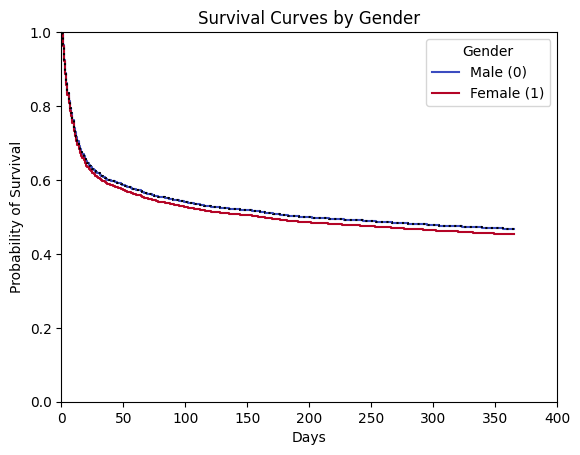

In [67]:
cph_pm.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,400)
plt.ylim(0,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.xlabel('Days')
plt.ylabel('Probability of Survival')
plt.show()

#### Method#2: Propensity Score Creation

In [139]:
# Define treatment and covariates
treatment = merged_copy['gender']
covariates = merged_copy.drop(columns=['gender', 'days_to_death', 'death_within_28_days', 'death_within_365_days',
                                       'subject_id', 'hadm_id','endpoint_365', 'censored_365', 'endpoint_28','censored_28'])
# Fit a logistic regression model to compute the propensity scores
model = LogisticRegression(max_iter=1000)
model.fit(covariates, treatment)

# Get the propensity scores
propensity_scores = model.predict_proba(covariates)[:, 1]

# Now you can match based on propensity scores (e.g., using nearest neighbor matching)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(propensity_scores.reshape(-1, 1))  # Reshape to ensure correct input format
distances, indices = nn.kneighbors(propensity_scores.reshape(-1, 1))

# Retrieve matched pairs or other matching methods as needed
matched_pairs = merged_copy.iloc[indices.flatten()]
matched_pairs['propensity_score'] = propensity_scores[indices.flatten()]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
cph_pm1 = CoxPHFitter()
cph_pm1.fit(
    matched_pairs[['gender', 'propensity_score', 'endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365'
)

cph_pm1.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.055031,1.056574,0.030331,-0.004416,0.114478,0.995594,1.121288,0.0,1.814366,6.962143e-02,3.844325
propensity_score,-1.739837,0.175549,0.205619,-2.142843,-1.336831,0.117321,0.262677,0.0,-8.461453,2.640656e-17,55.071881


In [141]:
cph_pm1.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.782718
Name: 365.0, dtype: float64

**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [142]:
cph_pm1.check_assumptions(matched_pairs[['gender', 'propensity_score', 'censored_365', 'endpoint_365']], p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8178 total observations, 3715 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
gender           km              5.25   0.02      5.51
                 rank            5.11   0.02      5.39
propensity_score km             29.78 <0.005     24.30
                 rank           30.92 <0.005     25.15



1. Variable 'gender' failed the non-proportional test: p-value is 0.0220.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

2. Variable 'propensity_score' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'propensity_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'propensity_score' using pd.cut, and then specify it in
`strata=['propensity_score', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assu

[]

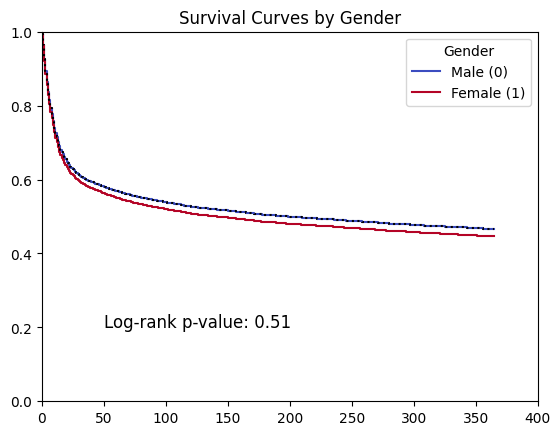

In [147]:
cph_pm1.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,400)
plt.ylim(0,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()

# 28-Days End Point

## 28-days Cox Proportional Hazard - Unadjusted

In [148]:
cph.fit(
    merged_copy[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.032915,1.033463,0.035358,-0.036386,0.102216,0.964268,1.107623,0.0,0.930909,0.351901,1.50676


In [149]:
cph.hazard_ratios_

covariate
gender    1.033463
Name: exp(coef), dtype: float64

In [150]:
cph.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.493355
Name: 28.0, dtype: float64

In [151]:
cph.check_assumptions(merged_copy[['gender', 'endpoint_28', 'censored_28']]
                      ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

## 28-days Cox Proportional Hazard - Adjusted

In [152]:
cph_aj = CoxPHFitter()

cph_aj.fit(
    merged_copy[['gender', 'charlson_comorbidity_index', 'apsiii_strata', 'std_sofa', 'endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
    formula="gender* apsiii_strata * charlson_comorbidity_index * std_sofa"
)
cph_aj.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,-0.074865,0.927869,0.359883,-0.780223,0.630494,0.458304,1.878538,0.0,-0.208025,8.352097e-01,0.259790
apsiii_strata,1.241965,3.462411,0.185126,0.879126,1.604805,2.408792,4.976887,0.0,6.708769,1.962726e-11,35.568351
charlson_comorbidity_index,0.193547,1.213546,0.032841,0.129180,0.257914,1.137895,1.294228,0.0,5.893469,3.781702e-09,27.978317
std_sofa,0.394838,1.484144,0.130348,0.139361,0.650315,1.149539,1.916145,0.0,3.029113,2.452727e-03,8.671398
gender:apsiii_strata,-0.107884,0.897732,0.273560,-0.644052,0.428284,0.525160,1.534622,0.0,-0.394370,6.933078e-01,0.528432
gender:charlson_comorbidity_index,0.031517,1.032019,0.051378,-0.069181,0.132215,0.933158,1.141354,0.0,0.613448,5.395801e-01,0.890091
apsiii_strata:charlson_comorbidity_index,-0.079589,0.923496,0.024950,-0.128491,-0.030687,0.879421,0.969779,0.0,-3.189907,1.423188e-03,9.456658
gender:std_sofa,0.215296,1.240228,0.190037,-0.157169,0.587760,0.854559,1.799953,0.0,1.132917,2.572492e-01,1.958761
apsiii_strata:std_sofa,-0.186201,0.830107,0.085815,-0.354396,-0.018006,0.701597,0.982155,0.0,-2.169785,3.002311e-02,5.057783


In [153]:
cph_aj.hazard_ratios_

covariate
gender                                                      0.927869
apsiii_strata                                               3.462411
charlson_comorbidity_index                                  1.213546
std_sofa                                                    1.484144
gender:apsiii_strata                                        0.897732
gender:charlson_comorbidity_index                           1.032019
apsiii_strata:charlson_comorbidity_index                    0.923496
gender:std_sofa                                             1.240228
apsiii_strata:std_sofa                                      0.830107
charlson_comorbidity_index:std_sofa                         0.988664
gender:apsiii_strata:charlson_comorbidity_index             0.996191
gender:apsiii_strata:std_sofa                               0.949521
gender:charlson_comorbidity_index:std_sofa                  0.968983
apsiii_strata:charlson_comorbidity_index:std_sofa           1.014341
gender:apsiii_strata:cha

In [154]:
cph_aj.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.426041
Name: 28.0, dtype: float64

**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [155]:
cph_aj.check_assumptions(merged_copy[['gender', 'charlson_comorbidity_index', 'apsiii_strata', 'std_sofa', 'endpoint_28', 'censored_28']]
                      ,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8178 total observations, 4963 right-censored observations>
         test_name = proportional_hazard_test

---
                                                               test_statistic    p  -log2(p)
apsiii_strata                                            km              0.78 0.38      1.40
                                                         rank            0.85 0.36      1.49
apsiii_strata:charlson_comorbidity_index                 km              0.93 0.33      1.58
                                                         rank            0.97 0.32      1.62
apsiii_strata:charlson_comorbidity_index:std_sofa        km              0.61 0.43      1.21
                                                         rank            0.69 0.41      1.30
apsiii_strata:std_sofa                                   km              2.01 0.16      2.68
                                                         rank            2.17 0.14      2.82
charlson_comorbidity_index                               km              6.96 0.01      6.91
                                                         rank            7.25 0.01      7.14
charlson_comorbidity_index:std_sofa                      km              1.09 0.30      1.76
                                                         rank            1.22 0.27      1.90
gender                                                   km              0.49 0.48      1.05
                                                         rank            0.51 0.48      1.07
gender:apsiii_strata                                     km              3.65 0.06      4.15
                                                         rank            3.73 0.05      4.23
gender:apsiii_strata:charlson_comorbidity_index          km              4.45 0.03      4.84
                                                         rank            4.63 0.03      5.00
gender:apsiii_strata:charlson_comorbidity_index:std_sofa km              2.69 0.10      3.31
                                                         rank            2.86 0.09      3.46
gender:apsiii_strata:std_sofa                            km              2.54 0.11      3.17
                                                         rank            2.61 0.11      3.24
gender:charlson_comorbidity_index                        km              2.32 0.13      2.97
                                                         rank            2.45 0.12      3.09
gender:charlson_comorbidity_index:std_sofa               km              1.30 0.25      1.98
                                                         rank            1.45 0.23      2.13
gender:std_sofa                                          km              0.41 0.52      0.94
                                                         rank            0.44 0.51      0.98
std_sofa                                                 km              3.45 0.06      3.98
                                                         rank            3.57 0.06      4.09



1. Variable 'charlson_comorbidity_index' failed the non-proportional test: p-value is 0.0071.

   Advice 1: the functional form of the variable 'charlson_comorbidity_index' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'charlson_comorbidity_index' using pd.cut, and then specify it
in `strata=['charlson_comorbidity_index', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'gender:apsiii_strata' failed the non-proportional test: p-value is 0.0533.

   Advice: with so few unique values (only 3), you can include `strata=['gender:apsiii_strata',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'gender:apsiii_str

[]

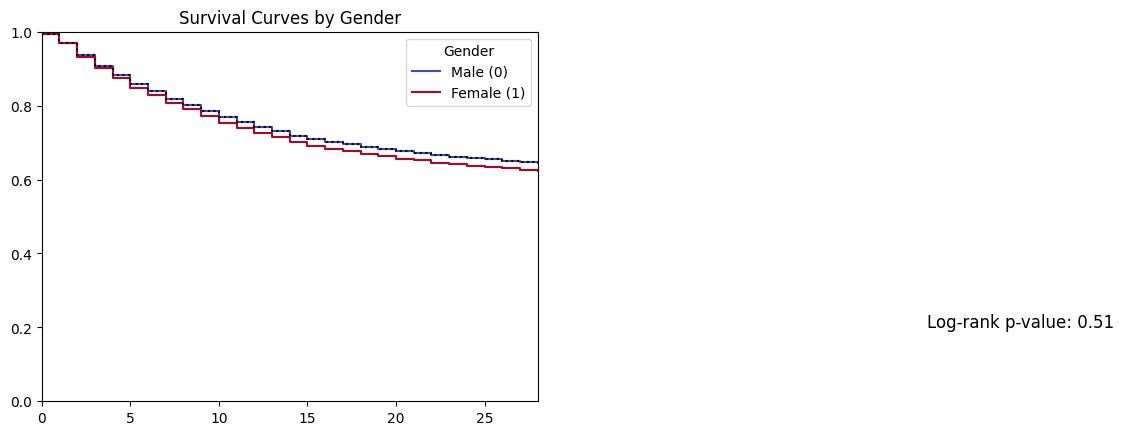

In [157]:
cph_aj.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,28)
plt.ylim(0,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()

## 28-days Cox Proportional Hazard Propensity - Score Matching 

#### Method#1: Propensity Cohort Creation

In [159]:
cph_pm = CoxPHFitter()
cph_pm.fit(matched_df[['gender','censored_28', 'endpoint_28']]
           , duration_col='endpoint_28'
           , event_col='censored_28')

cph_pm.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.072563,1.07526,0.037044,-0.000042,0.145167,0.999958,1.156233,0.0,1.958837,0.050132,4.318128


In [160]:
cph_pm.hazard_ratios_

covariate
gender    1.07526
Name: exp(coef), dtype: float64

In [161]:
cph_pm.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.483603
Name: 28.0, dtype: float64

**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [165]:
cph_pm.check_assumptions(matched_df[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7534 total observations, 4617 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic      p  -log2(p)
gender km              1.19   0.27      1.86
       rank           13.48 <0.005     12.02



1. Variable 'gender' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

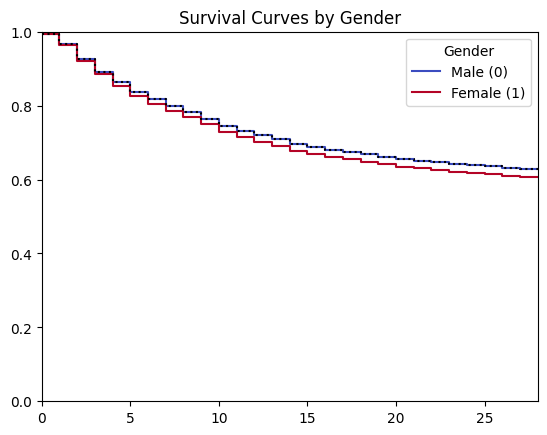

In [163]:
cph_pm.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,28)
plt.ylim(0,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()

#### Method#2: Propensity Score Creation

In [166]:
cph_pm1 = CoxPHFitter()
cph_pm1.fit(
    matched_pairs[['gender', 'propensity_score', 'endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28'
)

# Display the summary of the model
cph_pm1.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.084126,1.087766,0.035704,0.014147,0.154104,1.014247,1.166613,0.0,2.356188,1.846358e-02,5.759174
propensity_score,-2.503025,0.081837,0.240921,-2.975222,-2.030828,0.051036,0.131227,0.0,-10.389386,2.771318e-25,81.577630


In [167]:
cph_pm1.hazard_ratios_

covariate
gender              1.087766
propensity_score    0.081837
Name: exp(coef), dtype: float64

In [168]:
cph_pm1.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.489277
Name: 28.0, dtype: float64

In [169]:
cph_pm1.check_assumptions(matched_pairs[['gender','propensity_score','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

# Subgroup Analysis

### Subgroup One: age

In [172]:
merged_df['age'].median()

69.0

In [173]:
merged_copy['subgroup_69plus'] = (merged_copy['age'] > 69).astype(int)
older_subgroup = merged_copy[merged_copy['subgroup_69plus'] == 1]
younger_subgroup = merged_copy[merged_copy['subgroup_69plus'] == 0]

#### Subgroup One | One Year Endpoint

In [174]:
cph_sg1_o = CoxPHFitter()
cph_sg1_o.fit(
    older_subgroup[['gender','endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph_sg1_o.hazard_ratios_

covariate
gender    1.060633
Name: exp(coef), dtype: float64

In [175]:
cph_sg1_o.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.058866,1.060633,0.039521,-0.018593,0.136325,0.981578,1.146054,0.0,1.489494,0.136357,2.874535


In [176]:
cph_sg1_o.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.98355
Name: 365.0, dtype: float64

In [177]:
cph_sg1_o.check_assumptions(older_subgroup[['gender','censored_365', 'endpoint_365']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [178]:
cph_sg1_y = CoxPHFitter()
cph_sg1_y.fit(
    younger_subgroup[['gender','endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph_sg1_y.hazard_ratios_

covariate
gender    0.930705
Name: exp(coef), dtype: float64

In [179]:
cph_sg1_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,-0.071813,0.930705,0.046419,-0.162792,0.019167,0.849768,1.019351,0.0,-1.547059,0.121849,3.036834


In [180]:
cph_sg1_y.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.61685
Name: 365.0, dtype: float64

In [181]:
cph_sg1_y.check_assumptions(younger_subgroup[['gender','censored_365', 'endpoint_365']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

#### Subgroup One | 28-days Endpoint

In [182]:
cph_sg1_o.fit(
    older_subgroup[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph_sg1_o.hazard_ratios_

covariate
gender    1.061018
Name: exp(coef), dtype: float64

In [183]:
cph_sg1_o.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.059229,1.061018,0.04647,-0.03185,0.150308,0.968652,1.162192,0.0,1.274565,0.202463,2.304268


In [184]:
cph_sg1_o.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.598633
Name: 28.0, dtype: float64

**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [185]:
cph_sg1_o.check_assumptions(older_subgroup[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4070 total observations, 2217 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
gender km              4.86 0.03      5.19
       rank            4.45 0.03      4.84



1. Variable 'gender' failed the non-proportional test: p-value is 0.0275.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

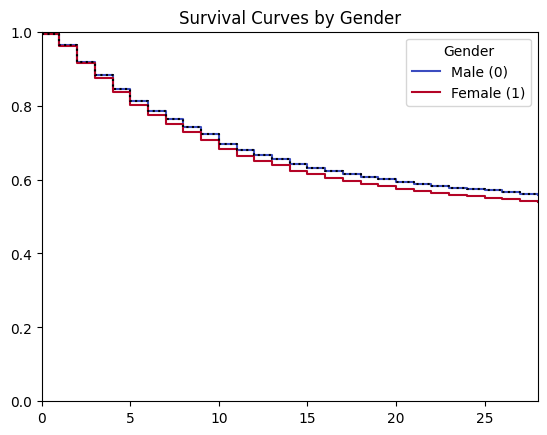

In [186]:
cph_sg1_o.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,28)
plt.ylim(0,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()

In [236]:
cph_sg1_y.fit(
    younger_subgroup[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph_sg1_y.hazard_ratios_

covariate
gender    0.963351
Name: exp(coef), dtype: float64

In [237]:
cph_sg1_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,-0.037338,0.963351,0.054728,-0.144603,0.069927,0.865366,1.07243,0.0,-0.682246,0.495084,1.014256


In [238]:
cph_sg1_y.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.39868
Name: 28.0, dtype: float64

In [240]:
cph_sg1_y.check_assumptions(younger_subgroup[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

### Subgroup Two: Sepsis

In [241]:
subgroup_sepsis_y = merged_copy[merged_copy['has_sepsis_at_admission']==1]
subgroup_sepsis_n = merged_copy[merged_copy['has_sepsis_at_admission']==0]

#### Subgroup Two | One Year Endpoint

In [242]:
cph_sg2_y = CoxPHFitter()
cph_sg2_y.fit(
    subgroup_sepsis_y[['gender','endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph_sg2_y.hazard_ratios_

covariate
gender    1.029397
Name: exp(coef), dtype: float64

In [243]:
cph_sg2_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.028974,1.029397,0.093254,-0.153802,0.211749,0.857442,1.235837,0.0,0.310694,0.756033,0.403479


In [244]:
cph_sg2_y.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    1.061986
Name: 365.0, dtype: float64

In [245]:
cph_sg2_y.check_assumptions(subgroup_sepsis_y[['gender','censored_365', 'endpoint_365']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

#### Subgroup Two | 28-days Endpoint

In [246]:
cph_sg2_y = CoxPHFitter()
cph_sg2_y.fit(
    subgroup_sepsis_y[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph_sg2_y.hazard_ratios_

covariate
gender    1.040701
Name: exp(coef), dtype: float64

In [247]:
cph_sg2_y.baseline_cumulative_hazard_.iloc[-1,:]

baseline cumulative hazard    0.667385
Name: 28.0, dtype: float64

In [248]:
cph_sg2_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.039894,1.040701,0.107786,-0.171362,0.251151,0.842516,1.285504,0.0,0.370126,0.711289,0.491492


In [249]:
cph_sg2_y.check_assumptions(subgroup_sepsis_y[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

### Subgroup Three: Neurological Diseases

In [187]:
subgroup_neuro_y = merged_copy[merged_copy['has_neurological_disease_at_admission']==1]
subgroup_neuro_n = merged_copy[merged_copy['has_neurological_disease_at_admission']==0]

Subgroup Three | One Year Endpoint

#### Subgroup Three | One Year Endpoint

In [251]:
cph_sg3_y = CoxPHFitter()
cph_sg3_y.fit(
    subgroup_neuro_y[['gender','endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph_sg3_y.hazard_ratios_

covariate
gender    0.87289
Name: exp(coef), dtype: float64

In [252]:
cph_sg3_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,-0.135945,0.87289,0.232784,-0.592194,0.320304,0.553112,1.377546,0.0,-0.583996,0.559223,0.838504


In [253]:
cph_sg3_y.check_assumptions(subgroup_neuro_y[['gender','censored_365', 'endpoint_365']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

#### Subgroup Three | 28-days Endpoint

In [188]:
cph_sg3_y = CoxPHFitter()
cph_sg3_y.fit(
    subgroup_neuro_y[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph_sg3_y.hazard_ratios_

covariate
gender    1.032021
Name: exp(coef), dtype: float64

In [189]:
cph_sg3_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.031519,1.032021,0.29234,-0.541456,0.604495,0.5819,1.830327,0.0,0.107818,0.91414,0.129513


**This regression, although didn't pass the assumptions, showed relatively proportional trends in survival rate among men and women.**

In [190]:
cph_sg3_y.check_assumptions(subgroup_neuro_y[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 163 total observations, 116 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
gender km              4.00 0.05      4.46
       rank            3.42 0.06      3.95



1. Variable 'gender' failed the non-proportional test: p-value is 0.0456.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

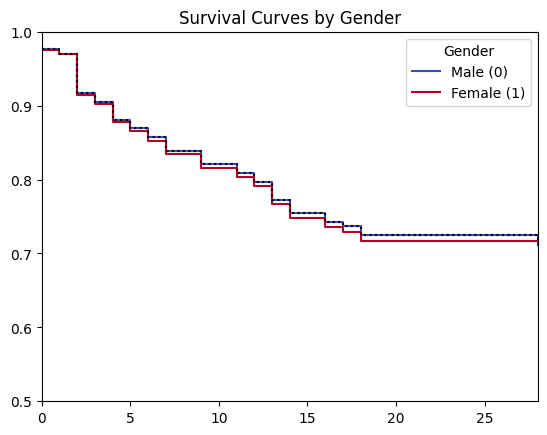

In [194]:
cph_sg3_y.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,28)
plt.ylim(0.5,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()

### Subgroup Four: Heart Failure

In [196]:
subgroup_heartFailure_y = merged_copy[merged_copy['has_heart_failure']==1]
subgroup_heartFailure_n = merged_copy[merged_copy['has_heart_failure']==0]

In [270]:
subgroup_heartFailure_y.shape

(3496, 53)

#### Subgroup Four | One Year Endpoint

In [258]:
cph_sg4_y = CoxPHFitter()
cph_sg4_y.fit(
    subgroup_heartFailure_y[['gender','endpoint_365', 'censored_365']],
    duration_col='endpoint_365',
    event_col='censored_365',
)
cph_sg4_y.hazard_ratios_

covariate
gender    1.01565
Name: exp(coef), dtype: float64

In [259]:
cph_sg4_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.015529,1.01565,0.043536,-0.069799,0.100857,0.932581,1.106119,0.0,0.3567,0.721317,0.471296


In [260]:
cph_sg4_y.check_assumptions(subgroup_heartFailure_y[['gender','censored_365', 'endpoint_365']]
                          ,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

#### Subgroup Four | 28-days Endpoint

In [197]:
cph_sg4_y = CoxPHFitter()
cph_sg4_y.fit(
    subgroup_heartFailure_y[['gender','endpoint_28', 'censored_28']],
    duration_col='endpoint_28',
    event_col='censored_28',
)
cph_sg4_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.027238,1.027612,0.052194,-0.07506,0.129537,0.927687,1.138301,0.0,0.521861,0.601767,0.732723


In [198]:
cph_sg4_y.hazard_ratios_

covariate
gender    1.027612
Name: exp(coef), dtype: float64

In [199]:
cph_sg4_y.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.027238,1.027612,0.052194,-0.07506,0.129537,0.927687,1.138301,0.0,0.521861,0.601767,0.732723


In [200]:
cph_sg4_y.check_assumptions(subgroup_heartFailure_y[['gender','censored_28', 'endpoint_28']]
                          ,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3496 total observations, 2021 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
gender km              6.56 0.01      6.59
       rank            6.22 0.01      6.31



1. Variable 'gender' failed the non-proportional test: p-value is 0.0104.

   Advice: with so few unique values (only 2), you can include `strata=['gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

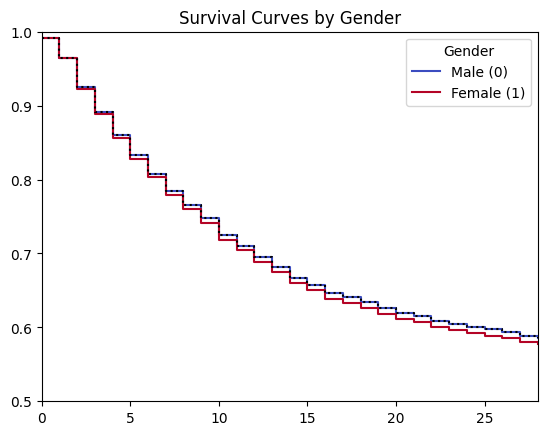

In [201]:
cph_sg4_y.plot_partial_effects_on_outcome(covariates='gender', values=[0, 1], cmap='coolwarm')
plt.title('Survival Curves by Gender')
plt.xlim(0,28)
plt.ylim(0.5,1)
plt.legend(['Male (0)', 'Female (1)'], title="Gender")
plt.show()